In [32]:
import os
import json
import pandas as pd
import re
import string
from tqdm import tqdm
from underthesea import word_tokenize
import joblib
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
import spacy
import networkx as nx
from numpy import dot
from numpy.linalg import norm
import matplotlib.pyplot as plt
# Đường dẫn gốc dự án
BASE_DIR = r"D:\Capstone_TinTuc"

# Load stopwords
STOPWORDS_PATH = os.path.join(BASE_DIR, "vietnamese_stopwords.txt")
with open(STOPWORDS_PATH, "r", encoding="utf-8") as f:
    stopwords = set(f.read().splitlines())

print(f"Đã load {len(stopwords)} stopwords.")

Đã load 54 stopwords.


In [22]:
def clean_text(text):
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^a-zA-ZÀ-Ỵà-ỵ0-9\s.,!?]", "", text)
    text = text.strip()
    return word_tokenize(text, format="text")
    
def process_json_folder_for_training(folder_path, output_csv=None):
    if output_csv is None:
        output_csv = os.path.join(BASE_DIR, "data", "labeled_data.csv")

    documents = []
    filenames = []
    labels = []

    for file in tqdm(os.listdir(folder_path)):
        if file.endswith(".json"):
            label = file.replace(".json", "").replace("vnexpress_", "")
            filepath = os.path.join(folder_path, file)

            with open(filepath, "r", encoding="utf-8") as f:
                data = json.load(f)

                for article in data:
                    title = article.get("title", "").strip()
                    content = article.get("content", "").strip()
                    full_text = f"{title}. {content}"

                    if full_text.strip():
                        documents.append(clean_text(full_text))
                        filenames.append(file)
                        labels.append(label)

    df = pd.DataFrame({
        "filename": filenames,
        "text": documents,
        "label": labels
    })

    df.to_csv(output_csv, index=False, encoding="utf-8-sig")
    print(f"Đã xử lý xong. Tổng số bài báo: {len(df)}. File lưu: {output_csv}")
    return df

In [23]:
folder_path = os.path.join(BASE_DIR, "data", "raw")  # thư mục chứa các file .json
df=process_json_folder_for_training(folder_path)
df.head()

100%|██████████████████████████████████| 11/11 [05:30<00:00, 30.05s/it]


Đã xử lý xong. Tổng số bài báo: 4685. File lưu: D:\Capstone_TinTuc\data\labeled_data.csv


,filename,text,label
0,vnexpress_doi-song.json,Xây phòng lớp mới cho học_sinh miền núi Quảng_...,doi-song
1,vnexpress_doi-song.json,Ngôi làng tặng nhà 100 m2 cho thanh_niên . Ngà...,doi-song
2,vnexpress_doi-song.json,Quan_hệ tình_dục nhiều có giúp vợ_chồng hạnh_p...,doi-song
3,vnexpress_doi-song.json,Mất bao_lâu để quên người_yêu cũ ? . Các chuyê...,doi-song
4,vnexpress_doi-song.json,Nghề dắt chó đi dạo_VnExpress .,doi-song


In [33]:
def train_and_predict_lda(csv_path):
    df = pd.read_csv(csv_path, encoding="utf-8-sig")
    
    # Chia dữ liệu train/test
    X_train, X_test, y_train, y_test = train_test_split(
        df["text"], df["label"], test_size=0.2, random_state=42
    )
    
    # Pipeline: Vector hóa + Naive Bayes
    clf = make_pipeline(CountVectorizer(), MultinomialNB())
    
    # Train
    clf.fit(X_train, y_train)
    
    # Dự đoán
    y_pred = clf.predict(X_test)
    
    # Báo cáo kết quả dạng text 
    report = classification_report(y_test, y_pred)
    print("- Báo cáo kết quả dạng text")
    print(report)

    #báo cáo kết quả dạng dict
    report_dict = classification_report(y_test, y_pred, output_dict=True)
    print("- Báo cáo kết quả dạng dict")
    print(report_dict)
    
    # Lưu mô hình
    save_path = os.path.join(BASE_DIR, "saved_models", "lda_model.joblib")
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    joblib.dump(clf, save_path)
    print(f" Mô hình đã được train và lưu tại: {save_path}")

    # Bước 9: Vẽ biểu đồ
    labels = [label for label in report_dict.keys() if label not in ("accuracy", "macro avg", "weighted avg")]
    precision = [report_dict[label]["precision"] for label in labels]
    recall = [report_dict[label]["recall"] for label in labels]
    f1_score = [report_dict[label]["f1-score"] for label in labels]

    x = range(len(labels))
    plt.figure(figsize=(10, 6))
    plt.bar(x, precision, width=0.25, label="Precision")
    plt.bar([i+0.25 for i in x], recall, width=0.25, label="Recall")
    plt.bar([i+0.5 for i in x], f1_score, width=0.25, label="F1-score")

    plt.xticks([i+0.25 for i in x], labels, rotation=45)
    plt.ylabel("Score")
    plt.title("Classification Metrics by Label")
    plt.legend()
    plt.tight_layout()
    print("- Vẽ biểu đồ")
    plt.show()
    
    return report

- Báo cáo kết quả dạng text
              precision    recall  f1-score   support

    doi-song       0.83      0.85      0.84       106
     du-lich       0.79      0.92      0.85        97
    giai-tri       0.96      0.92      0.94        98
    giao-duc       0.96      0.84      0.89        86
  kinh-doanh       0.81      0.90      0.85        78
   phap-luat       0.91      0.88      0.90       103
    suc-khoe       0.90      0.91      0.90        85
    the-gioi       0.89      0.84      0.86        75
    the-thao       0.99      0.95      0.97       102
     thoi-su       0.83      0.82      0.83       107

    accuracy                           0.88       937
   macro avg       0.89      0.88      0.88       937
weighted avg       0.89      0.88      0.88       937

- Báo cáo kết quả dạng dict
{'doi-song': {'precision': 0.8333333333333334, 'recall': 0.8490566037735849, 'f1-score': 0.8411214953271028, 'support': 106.0}, 'du-lich': {'precision': 0.7876106194690266, 'recall': 0.

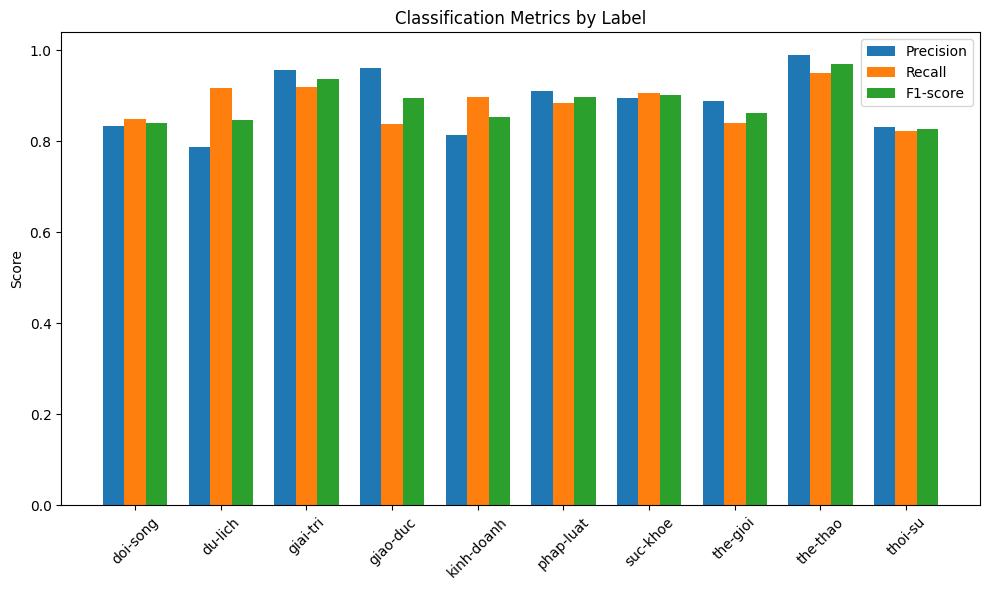

In [34]:
csv_path = os.path.join(BASE_DIR, "data", "labeled_data.csv")
report = train_and_predict_lda(csv_path)

In [44]:
def clean_text(text):
    text = re.sub(r"\s+", " ", text)
    text = re.sub(r"[^a-zA-ZÀ-Ỵà-ỵ0-9\s.,!?]", "", text)
    text = text.strip()
    return word_tokenize(text, format="text")

def preprocess_new_texts(texts):
    if isinstance(texts, str):
        texts = [texts]
    return [clean_text(t) for t in texts]

def predict_with_lda(model_path, new_texts):
    clf = joblib.load(model_path)
    # Nếu đầu vào là chuỗi đơn, đổi thành list
    if isinstance(new_texts, str):
        new_texts = [new_texts]
    cleaned_texts = preprocess_new_texts(new_texts)
    preds = clf.predict(cleaned_texts)
    return preds


In [45]:
sample_text = """
Việt Nam đang phát triển mạnh mẽ trong lĩnh vực công nghệ thông tin.
Nhiều doanh nghiệp khởi nghiệp sáng tạo được thành lập với nhiều dự án tiềm năng.
Chính phủ cũng đang thúc đẩy đầu tư và phát triển hạ tầng kỹ thuật số.
"""

# Đường dẫn mô hình
model_path = os.path.join(BASE_DIR, "saved_models", "lda_model.joblib")

# Dự đoán cho đoạn bài báo mẫu
predicted_label = predict_with_lda(model_path, sample_text)

print("Bài báo mẫu:")
print(sample_text)
print("\nDự đoán topic:")
print(predicted_label[0])


Bài báo mẫu:

Việt Nam đang phát triển mạnh mẽ trong lĩnh vực công nghệ thông tin.
Nhiều doanh nghiệp khởi nghiệp sáng tạo được thành lập với nhiều dự án tiềm năng.
Chính phủ cũng đang thúc đẩy đầu tư và phát triển hạ tầng kỹ thuật số.


Dự đoán topic:
kinh-doanh


In [46]:
nlp = spacy.load("vi_core_news_lg")

def clean_text_textrank(text: str) -> str:
    # Bỏ ký tự đặc biệt và xuống dòng
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'[^\w\s.,]', '', text)  # Giữ dấu chấm, phẩy để chia câu
    return text.lower()

def cosine_sim(v1, v2):
    return dot(v1, v2) / (norm(v1) * norm(v2) + 1e-10)  # +1e-10 tránh chia 0

def textrank_summarize(text: str, num_sentences: int = 3) -> str:
    cleaned_text = clean_text_textrank(text)
    doc = nlp(cleaned_text)
    sentences = [sent.text.strip() for sent in doc.sents if sent.text.strip()]
    if len(sentences) <= num_sentences:
        return text

    # Chuyển câu thành vector
    sentence_vectors = []
    for sent in sentences:
        if nlp(sent).has_vector:
            sentence_vectors.append(nlp(sent).vector)
        else:
            sentence_vectors.append(nlp("văn bản").vector)  # fallback nếu không có vector

    similarity_matrix = nx.Graph()
    for i in range(len(sentences)):
        for j in range(i + 1, len(sentences)):
            sim = cosine_sim(sentence_vectors[i], sentence_vectors[j])
            similarity_matrix.add_edge(i, j, weight=sim)

    scores = nx.pagerank(similarity_matrix)
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    selected = [s for _, s in ranked_sentences[:num_sentences]]
    # Sắp xếp theo thứ tự gốc trong văn bản
    ordered_summary = [s for s in sentences if s in selected]
    return " ".join(ordered_summary)

In [47]:
# Ví dụ đoạn văn để test
sample_text = """
Việt Nam đang phát triển mạnh mẽ trong lĩnh vực công nghệ thông tin.
Nhiều doanh nghiệp khởi nghiệp sáng tạo được thành lập với nhiều dự án tiềm năng.
Chính phủ cũng đang thúc đẩy đầu tư và phát triển hạ tầng kỹ thuật số.
"""

summary = textrank_summarize(sample_text, num_sentences=2)
print("Tóm tắt TextRank:")
print(summary)

Tóm tắt TextRank:
việt nam đang phát triển mạnh mẽ trong lĩnh vực công nghệ thông tin. chính phủ cũng đang thúc đẩy đầu tư và phát triển hạ tầng kỹ thuật số.
